In [1]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import geopandas as gpd

import cartopy.feature as cf
import cartopy.crs as ccrs

from matplotlib import patches
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

sys.path.append(os.path.abspath("../../function"))
from others import haversine, NSE, relative_error, spearman_corr, MAE, RMSE, MBE

In [2]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Brazil')

## IMERG Early

In [3]:
DATA = xr.open_dataset('/home/arturo/Downloads/IMERG_early/IMERG_SA_early_1dy_2024_01_01_2024_12_31.nc')
lon2d_IM, lat2d_IM = np.meshgrid(DATA.lon.values, DATA.lat.values)
IMERG = DATA.PRE.values
IMERG.shape

(366, 611, 501)

## GSMaP-NRT

In [4]:
DATA = xr.open_dataset('/media/arturo/Arturo/Data/Brazil/GSMaP/NRT/GSMaP_NRT_SA_1dy_2024_01_01_2024_12_31.nc')
# DATA = DATA.sel(time=slice("2024-03-01", "2024-12-31"))
lon2d, lat2d = np.meshgrid(DATA.lon.values, DATA.lat.values)
GSMaP_NRT = DATA.PRE.values
GSMaP_NRT.shape

(366, 610, 500)

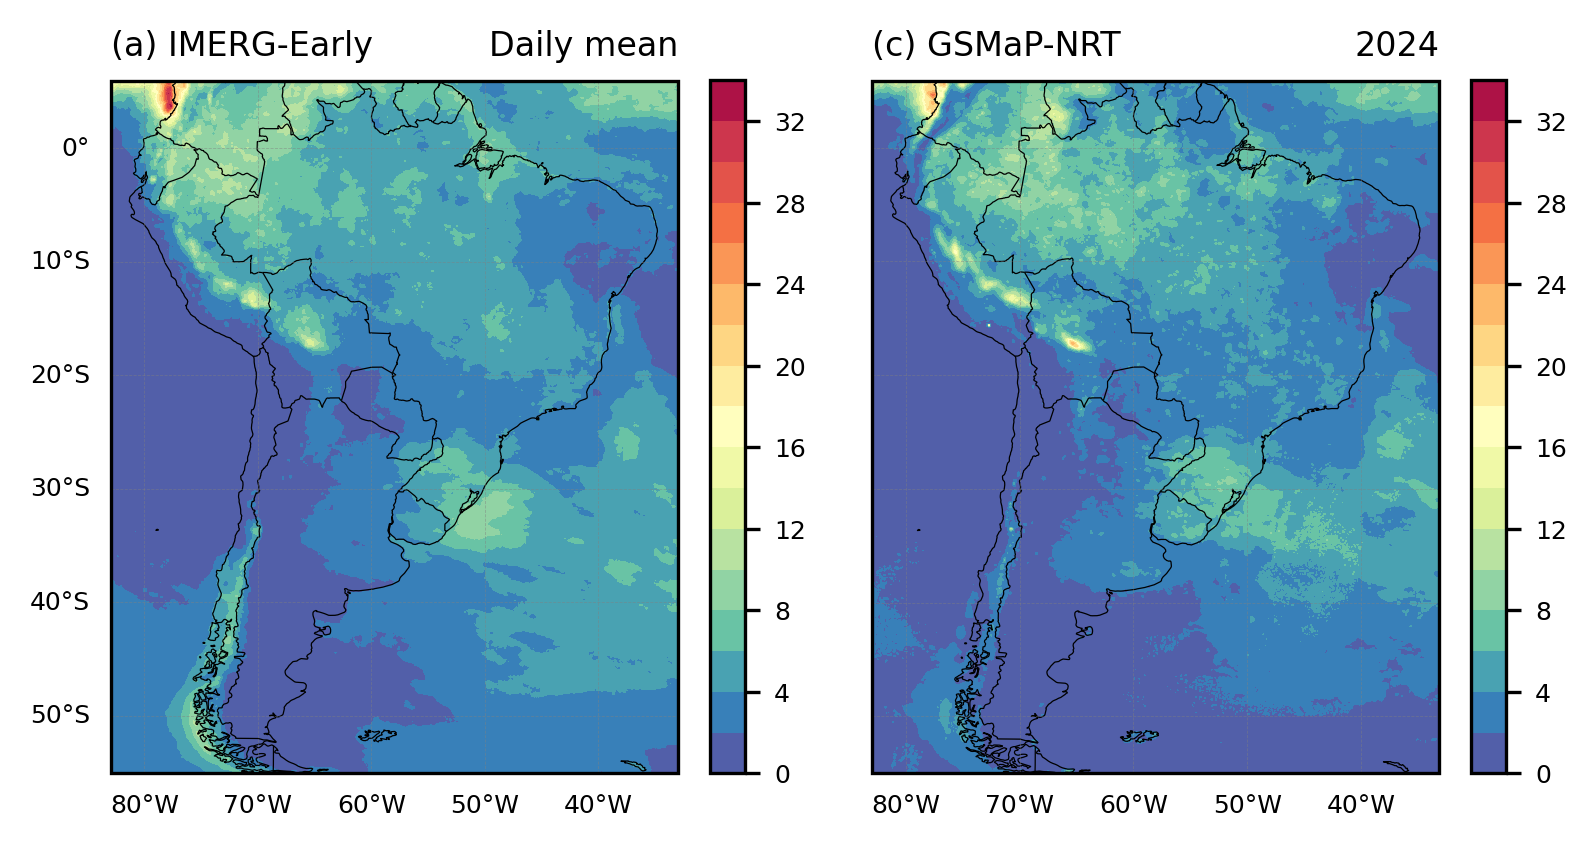

In [20]:
levels = np.arange(0,36,2)
# levels = None

cmap = plt.cm.Spectral_r

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,2)

#==================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
# ax1.set_extent([-87,-30,-50,15],crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.3, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.3, linestyle='-', edgecolor='k')

a1 = ax1.contourf(lon2d_IM, lat2d_IM, np.mean(IMERG,axis=0),levels=levels, cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 6, 'color': 'k'}
gl.ylabel_style = {'size': 6, 'color': 'k'}

cbar = plt.colorbar(a1, orientation='vertical', pad=0.05, fraction=0.055)
cbar.ax.tick_params(labelsize=6)

ax1.set_title('(a) IMERG-Early', loc='left', fontsize=8)
ax1.set_title('Daily mean', loc='right', fontsize=8)

#==================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
# ax1.set_extent([-87,-30,-50,15],crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.3, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.3, linestyle='-', edgecolor='k')

a1 = ax1.contourf(lon2d, lat2d, np.mean(GSMaP_NRT,axis=0),levels=levels, cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 6, 'color': 'k'}
gl.ylabel_style = {'size': 6, 'color': 'k'}

cbar = plt.colorbar(a1, orientation='vertical', pad=0.05, fraction=0.055)
cbar.ax.tick_params(labelsize=6)

ax1.set_title('(c) GSMaP-NRT', loc='left', fontsize=8)
ax1.set_title('2024', loc='right', fontsize=8)

#==================================================================================================
ax1.set_facecolor('white')
fig.patch.set_alpha(0)

## OBS-CPTEC

In [6]:
CPTEC_INFO = pd.read_csv(os.path.join(dir_base,'OBS_CPTEC','1dy','INFO_final.csv'))
print(f'NUmber of files: {len(CPTEC_INFO)}')

NUmber of files: 3533


In [7]:
# Remove station with stange values
CPTEC_INFO = CPTEC_INFO[~((CPTEC_INFO['Lat'] == -34.67) & (CPTEC_INFO['Lon'] == -58.64))]
CPTEC_INFO = CPTEC_INFO[~((CPTEC_INFO['Lat'] == -7.3) & (CPTEC_INFO['Lon'] == -39.27))]
CPTEC_INFO = CPTEC_INFO[~((CPTEC_INFO['Lat'] == -30.96) & (CPTEC_INFO['Lon'] == -61.53))]
CPTEC_INFO = CPTEC_INFO[~((CPTEC_INFO['Lat'] == 5.71) & (CPTEC_INFO['Lon'] == -76.62))]
CPTEC_INFO = CPTEC_INFO.reset_index(drop=True)

In [8]:
RMSE_IMERG, COR_IMERG, NSE_IMERG, MAE_IMERG, RE_IMERG, MRE_IMERG = [], [], [], [], [], []
RAIN_IMERG, RAIN_OBS = [], []

lat_ref, lon_ref = [], []

for nn in range(len(CPTEC_INFO)):

    obs = pd.read_csv(os.path.join(dir_base,'OBS_CPTEC','1dy','final',CPTEC_INFO.File[nn]))
    obs['time'] = pd.to_datetime(obs['time'])

    start = '2024-01-01'
    end = '2024-12-31'
    obs_filtered = obs[(obs['time'] >= start) & (obs['time'] <= end)]
    obs_filtered = obs_filtered.drop_duplicates(subset='time', keep='first')
    obs_filtered = obs_filtered.reset_index(drop=True)

    PRE_obs = obs_filtered['pre'].values

    lat_obs = CPTEC_INFO['Lat'].values[nn]
    lon_obs = CPTEC_INFO['Lon'].values[nn]
    lat_ref.append(CPTEC_INFO['Lat'].values[nn])
    lon_ref.append(CPTEC_INFO['Lon'].values[nn])
    
    distances = haversine(lon2d_IM, lat2d_IM, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    PRE_sat = IMERG[:,min_index[0],min_index[1]]

    PRE_sat_rdy = PRE_sat[~np.isnan(PRE_obs)]
    PRE_obs_rdy = PRE_obs[~np.isnan(PRE_obs)]

    RAIN_IMERG.append(PRE_sat_rdy)
    RAIN_OBS.append(PRE_obs_rdy)

    RMSE_tmp = RMSE(PRE_sat_rdy,PRE_obs_rdy)
    COR_tmp = spearman_corr(PRE_sat_rdy,PRE_obs_rdy)
    NSE_tmp = NSE(PRE_sat_rdy,PRE_obs_rdy)
    MAE_tmp = MBE(PRE_sat_rdy,PRE_obs_rdy)
    RE_tmp = relative_error(PRE_sat_rdy,PRE_obs_rdy)

    RMSE_IMERG.append(float(RMSE_tmp))
    COR_IMERG.append(float(COR_tmp))
    NSE_IMERG.append(float(NSE_tmp))
    MAE_IMERG.append(float(MAE_tmp))
    RE_IMERG.append(RE_tmp)
    MRE_IMERG.append(float(np.nanmean(RE_tmp)))

RE_IMERG = [item for matriz in RE_IMERG for item in matriz.flatten()]
RAIN_IMERG = [item for matriz in RAIN_IMERG for item in matriz.flatten()]
RAIN_OBS = [item for matriz in RAIN_OBS for item in matriz.flatten()]

In [9]:
RMSE_GSMaP_NRT, COR_GSMaP_NRT, NSE_GSMaP_NRT, MAE_GSMaP_NRT, RE_GSMaP_NRT, MRE_GSMaP_NRT = [], [], [], [], [], []
RAIN_GSMaP_NRT = []

lat_ref, lon_ref = [], []

for nn in range(len(CPTEC_INFO)):

    obs = pd.read_csv(os.path.join(dir_base,'OBS_CPTEC','1dy','final',CPTEC_INFO.File[nn]))
    obs['time'] = pd.to_datetime(obs['time'])

    start = '2024-01-01'
    end = '2024-12-31'
    obs_filtered = obs[(obs['time'] >= start) & (obs['time'] <= end)]
    obs_filtered = obs_filtered.drop_duplicates(subset='time', keep='first')
    obs_filtered = obs_filtered.reset_index(drop=True)

    PRE_obs = obs_filtered['pre'].values

    lat_obs = CPTEC_INFO['Lat'].values[nn]
    lon_obs = CPTEC_INFO['Lon'].values[nn]
    lat_ref.append(CPTEC_INFO['Lat'].values[nn])
    lon_ref.append(CPTEC_INFO['Lon'].values[nn])

    distances = haversine(lon2d, lat2d, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    PRE_sat = GSMaP_NRT[:,min_index[0],min_index[1]]
    PRE_sat_rdy = PRE_sat[~np.isnan(PRE_obs)]
    PRE_obs_rdy = PRE_obs[~np.isnan(PRE_obs)]
    RAIN_GSMaP_NRT.append(PRE_sat_rdy)

    RMSE_tmp = RMSE(PRE_sat_rdy,PRE_obs_rdy)
    COR_tmp = spearman_corr(PRE_sat_rdy,PRE_obs_rdy)
    NSE_tmp = NSE(PRE_sat_rdy,PRE_obs_rdy)
    MAE_tmp = MBE(PRE_sat_rdy,PRE_obs_rdy)
    RE_tmp = relative_error(PRE_sat_rdy,PRE_obs_rdy)

    RMSE_GSMaP_NRT.append(float(RMSE_tmp))
    COR_GSMaP_NRT.append(float(COR_tmp))
    NSE_GSMaP_NRT.append(float(NSE_tmp))
    MAE_GSMaP_NRT.append(float(MAE_tmp))
    RE_GSMaP_NRT.append(RE_tmp)
    MRE_GSMaP_NRT.append(float(np.nanmean(RE_tmp)))

RE_GSMaP_NRT = [item for matriz in RE_GSMaP_NRT for item in matriz.flatten()]
RAIN_GSMaP_NRT = [item for matriz in RAIN_GSMaP_NRT for item in matriz.flatten()]

In [10]:
np.nanmax(RMSE_IMERG), np.nanmax(RMSE_GSMaP_NRT)

(np.float64(33.23514119389121), np.float64(30.3720439005909))

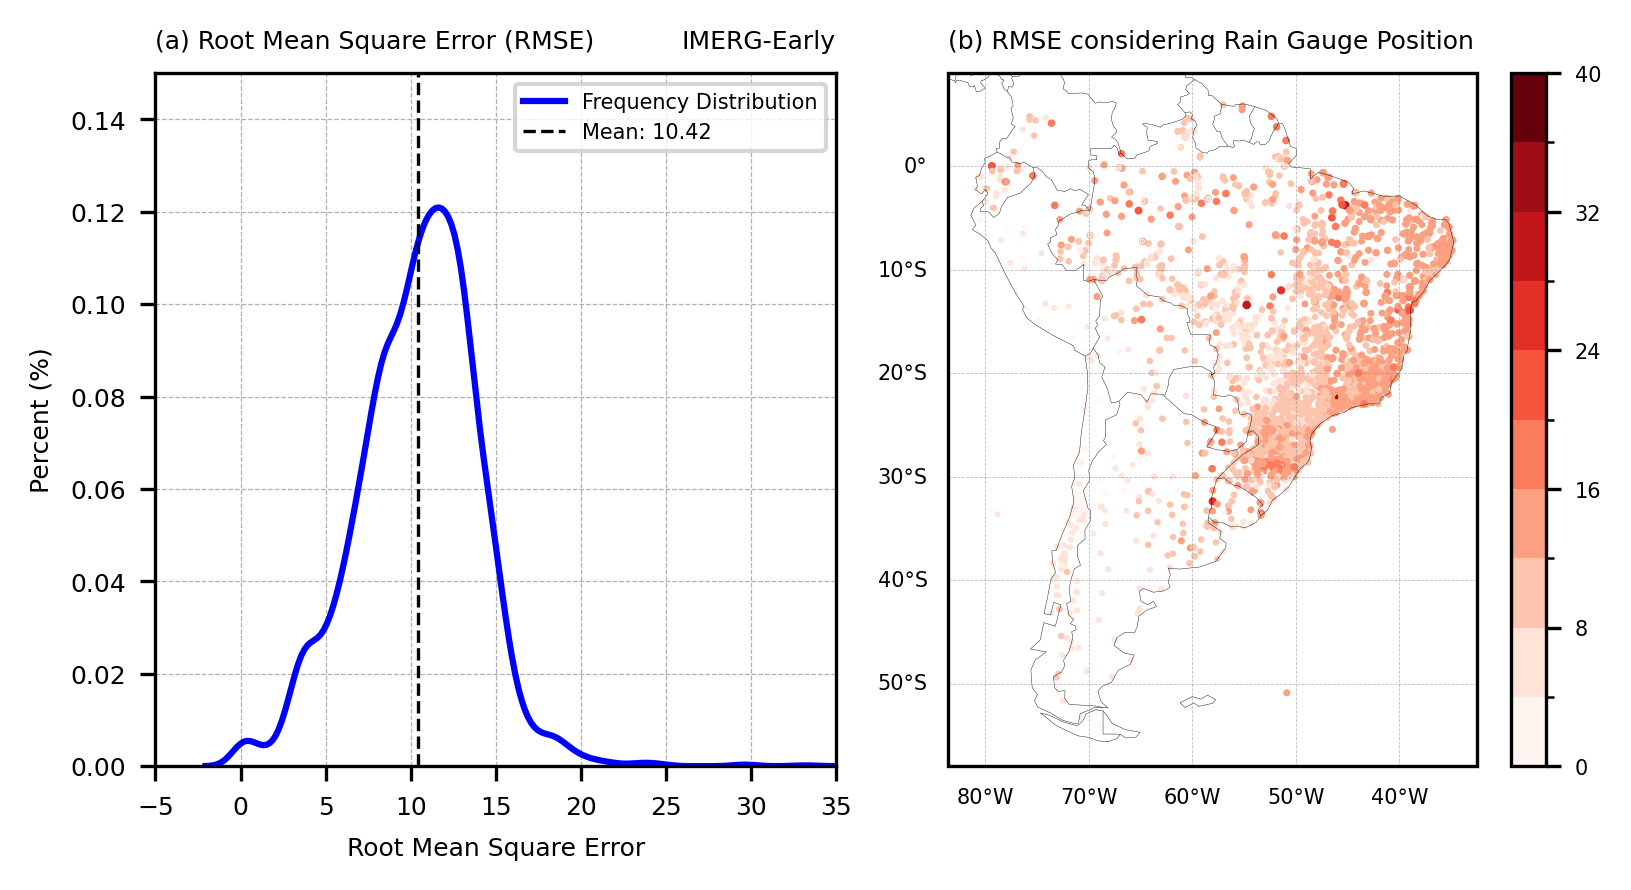

In [ ]:
levels = np.arange(0, 44, 4)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

cmap = plt.cm.Reds

fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,2)

#==================================================================================================
ax1 = plt.subplot(gs[0, 0])
sns.kdeplot(RMSE_IMERG,color='blue',cumulative=False,fill=False,multiple="stack",ax=ax1, label='Frequency Distribution')
ax1.axvline(np.mean(RMSE_IMERG),color='k',linestyle='--',linewidth=0.8, label=f'Mean: {np.round(np.mean(RMSE_IMERG),2)}')
# ax1.axvline(0,color='k',linestyle='-',linewidth=0.4, label=f'Zero error')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_xlim(-5,35)
ax1.set_ylim(0,0.15)
ax1.set_xlabel('Root Mean Square Error',fontsize=6)
ax1.set_ylabel('Percent (%)',fontsize=6)
ax1.set_title('(a) Root Mean Square Error (RMSE)', loc='left', fontsize=6)
ax1.set_title('IMERG-Early', loc='right', fontsize=6)
ax1.legend(fontsize=5,loc=1)

#================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.1, linestyle='-', edgecolor='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}
ax1.set_title('(b) RMSE using Rain Gauge Position', loc='left', fontsize=6)

a1 = ax1.scatter(lon_ref,lat_ref,s=5*(RMSE_IMERG/np.nanmax(RMSE_IMERG)),marker='.',c=RMSE_IMERG,cmap=cmap,norm=norm)
cbar = plt.colorbar(a1, fraction=0.058)
cbar.ax.tick_params(labelsize=5)

#==================================================================================================
plt.subplots_adjust(wspace=0.05, hspace=0.2)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

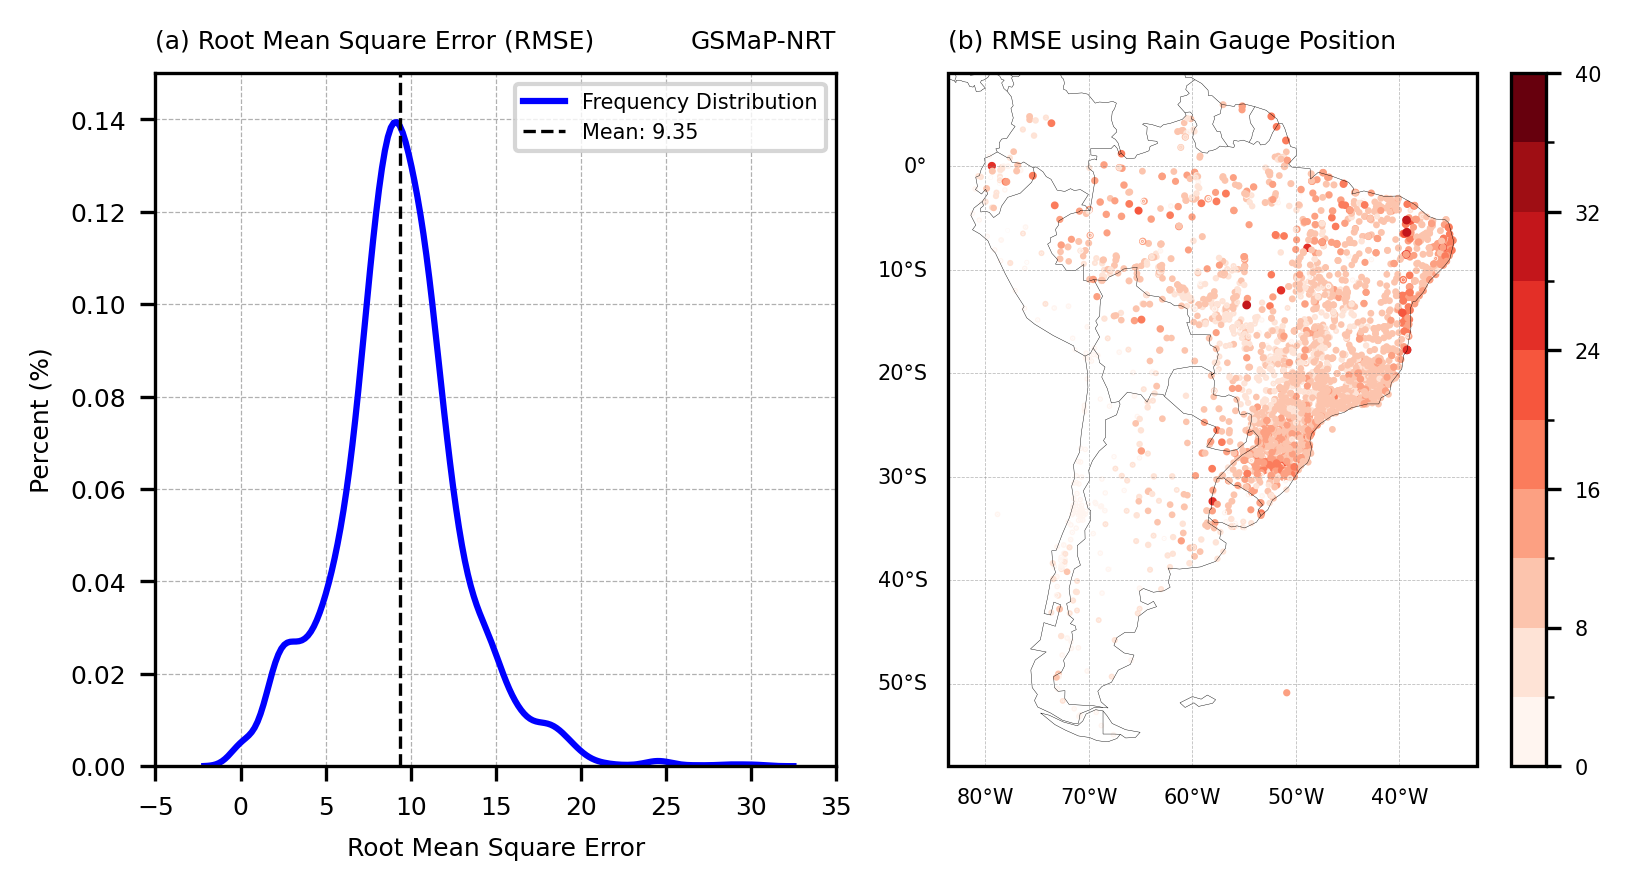

In [87]:
levels = np.arange(0, 44, 4)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

cmap = plt.cm.Reds

fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,2)

#==================================================================================================
ax1 = plt.subplot(gs[0, 0])
sns.kdeplot(RMSE_GSMaP_NRT,color='blue',cumulative=False,fill=False,multiple="stack",ax=ax1, label='Frequency Distribution')
ax1.axvline(np.mean(RMSE_GSMaP_NRT),color='k',linestyle='--',linewidth=0.8, label=f'Mean: {np.round(np.mean(RMSE_GSMaP_NRT),2)}')
# ax1.axvline(0,color='k',linestyle='-',linewidth=0.4, label=f'Zero error')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_xlim(-5,35)
ax1.set_ylim(0,0.15)
ax1.set_xlabel('Root Mean Square Error',fontsize=6)
ax1.set_ylabel('Percent (%)',fontsize=6)
ax1.set_title('(a) Root Mean Square Error (RMSE)', loc='left', fontsize=6)
ax1.set_title('GSMaP-NRT', loc='right', fontsize=6)
ax1.legend(fontsize=5,loc=1)

#================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.1, linestyle='-', edgecolor='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}
ax1.set_title('(b) RMSE using Rain Gauge Position', loc='left', fontsize=6)

a1 = ax1.scatter(lon_ref,lat_ref,s=5*(RMSE_GSMaP_NRT/np.nanmax(RMSE_GSMaP_NRT)),marker='.',c=RMSE_GSMaP_NRT,cmap=cmap,norm=norm)
cbar = plt.colorbar(a1, fraction=0.058)
cbar.ax.tick_params(labelsize=5)

#==================================================================================================
plt.subplots_adjust(wspace=0.05, hspace=0.2)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

In [12]:
print(np.nanmax(MAE_IMERG), np.nanmax(MAE_GSMaP_NRT))
print(np.nanmin(MAE_IMERG), np.nanmin(MAE_GSMaP_NRT))

16.089998722076416 8.589221954345703
-20.298333325920005 -20.495774982372918


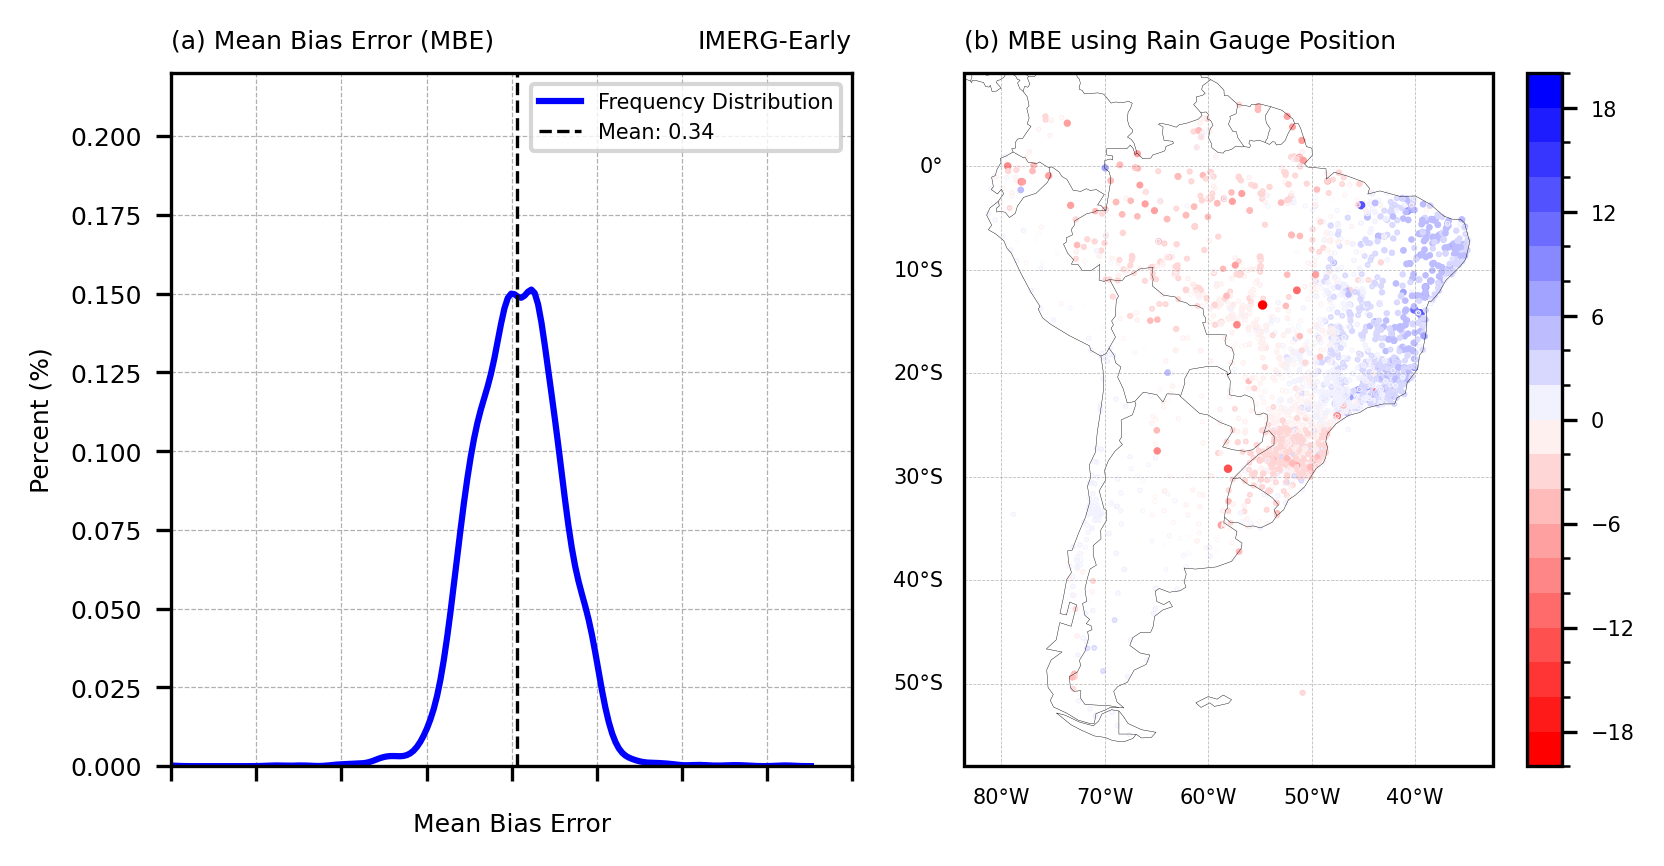

In [86]:
levels = np.arange(-20, 22, 2)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

cmap = plt.cm.bwr_r

fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,2)

#==================================================================================================
ax1 = plt.subplot(gs[0, 0])
sns.kdeplot(MAE_IMERG,color='blue',cumulative=False,fill=False,multiple="stack",ax=ax1, label='Frequency Distribution')
ax1.axvline(np.mean(MAE_IMERG),color='k',linestyle='--',linewidth=0.8, label=f'Mean: {np.round(np.mean(MAE_IMERG),2)}')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_xlim(-20,20)
ax1.set_ylim(0,0.22)
ax1.set_xticklabels([])
ax1.set_xlabel('Mean Bias Error',fontsize=6)
ax1.set_ylabel('Percent (%)',fontsize=6)
ax1.set_title('(a) Mean Bias Error (MBE)', loc='left', fontsize=6)
ax1.set_title('IMERG-Early', loc='right', fontsize=6)
ax1.legend(fontsize=5,loc=1)

#================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.1, linestyle='-', edgecolor='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}
ax1.set_title('(b) MBE using Rain Gauge Position', loc='left', fontsize=6)

a1 = ax1.scatter(lon_ref,lat_ref,s=5*abs(MAE_IMERG/np.nanmax(MAE_IMERG)),marker='.',c=MAE_IMERG,cmap=cmap,norm=norm)
cbar = plt.colorbar(a1, fraction=0.058)
cbar.ax.tick_params(labelsize=5)

#==================================================================================================
plt.subplots_adjust(wspace=0.05, hspace=0.2)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

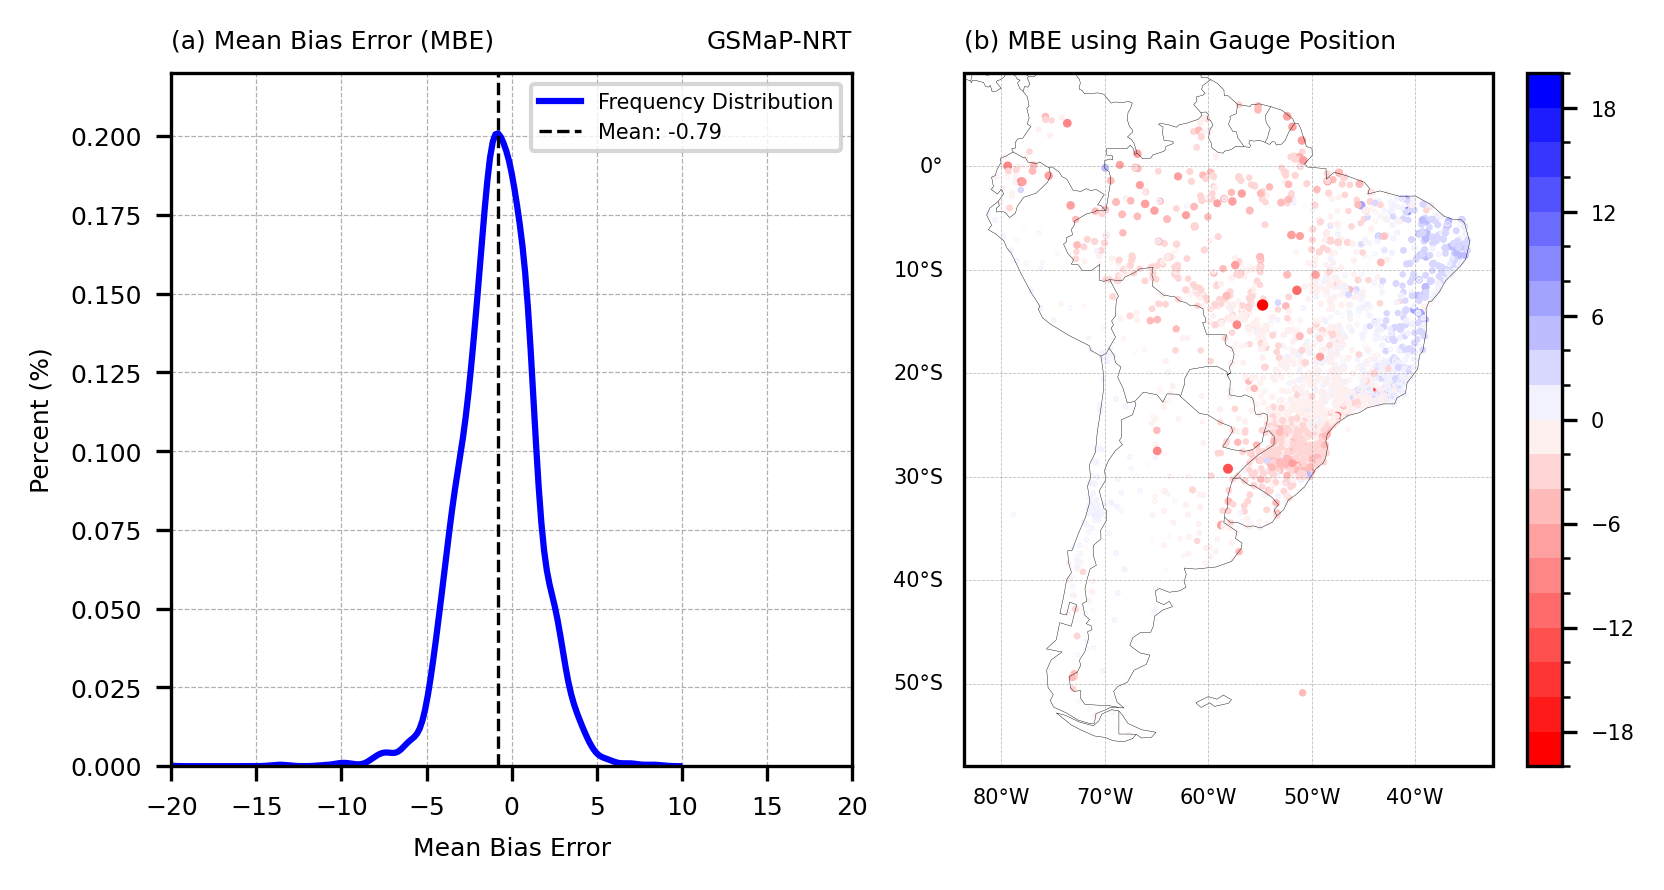

In [89]:
levels = np.arange(-20, 22, 2)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

cmap = plt.cm.bwr_r

fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,2)

#==================================================================================================
ax1 = plt.subplot(gs[0, 0])
sns.kdeplot(MAE_GSMaP_NRT,color='blue',cumulative=False,fill=False,multiple="stack",ax=ax1, label='Frequency Distribution')
ax1.axvline(np.mean(MAE_GSMaP_NRT),color='k',linestyle='--',linewidth=0.8, label=f'Mean: {np.round(np.mean(MAE_GSMaP_NRT),2)}')
# ax1.axvline(0,color='k',linestyle='-',linewidth=0.4, label=f'Zero error')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_xlim(-20,20)
ax1.set_ylim(0,0.22)
ax1.set_xlabel('Mean Bias Error',fontsize=6)
ax1.set_ylabel('Percent (%)',fontsize=6)
ax1.set_title('(a) Mean Bias Error (MBE)', loc='left', fontsize=6)
ax1.set_title('GSMaP-NRT', loc='right', fontsize=6)
ax1.legend(fontsize=5,loc=1)

#================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.1, linestyle='-', edgecolor='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}
ax1.set_title('(b) MBE using Rain Gauge Position', loc='left', fontsize=6)

a1 = ax1.scatter(lon_ref,lat_ref,s=5*abs(MAE_GSMaP_NRT/np.nanmax(MAE_GSMaP_NRT)),marker='.',c=MAE_GSMaP_NRT,cmap=cmap,norm=norm)
cbar = plt.colorbar(a1, fraction=0.058)
cbar.ax.tick_params(labelsize=5)

#==================================================================================================
plt.subplots_adjust(wspace=0.05, hspace=0.2)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

In [14]:
print(np.nanmax(COR_IMERG), np.nanmax(COR_GSMaP_NRT))
print(np.nanmin(COR_IMERG), np.nanmin(COR_GSMaP_NRT))

1.0 1.0
-0.9999999999999999 -1.0


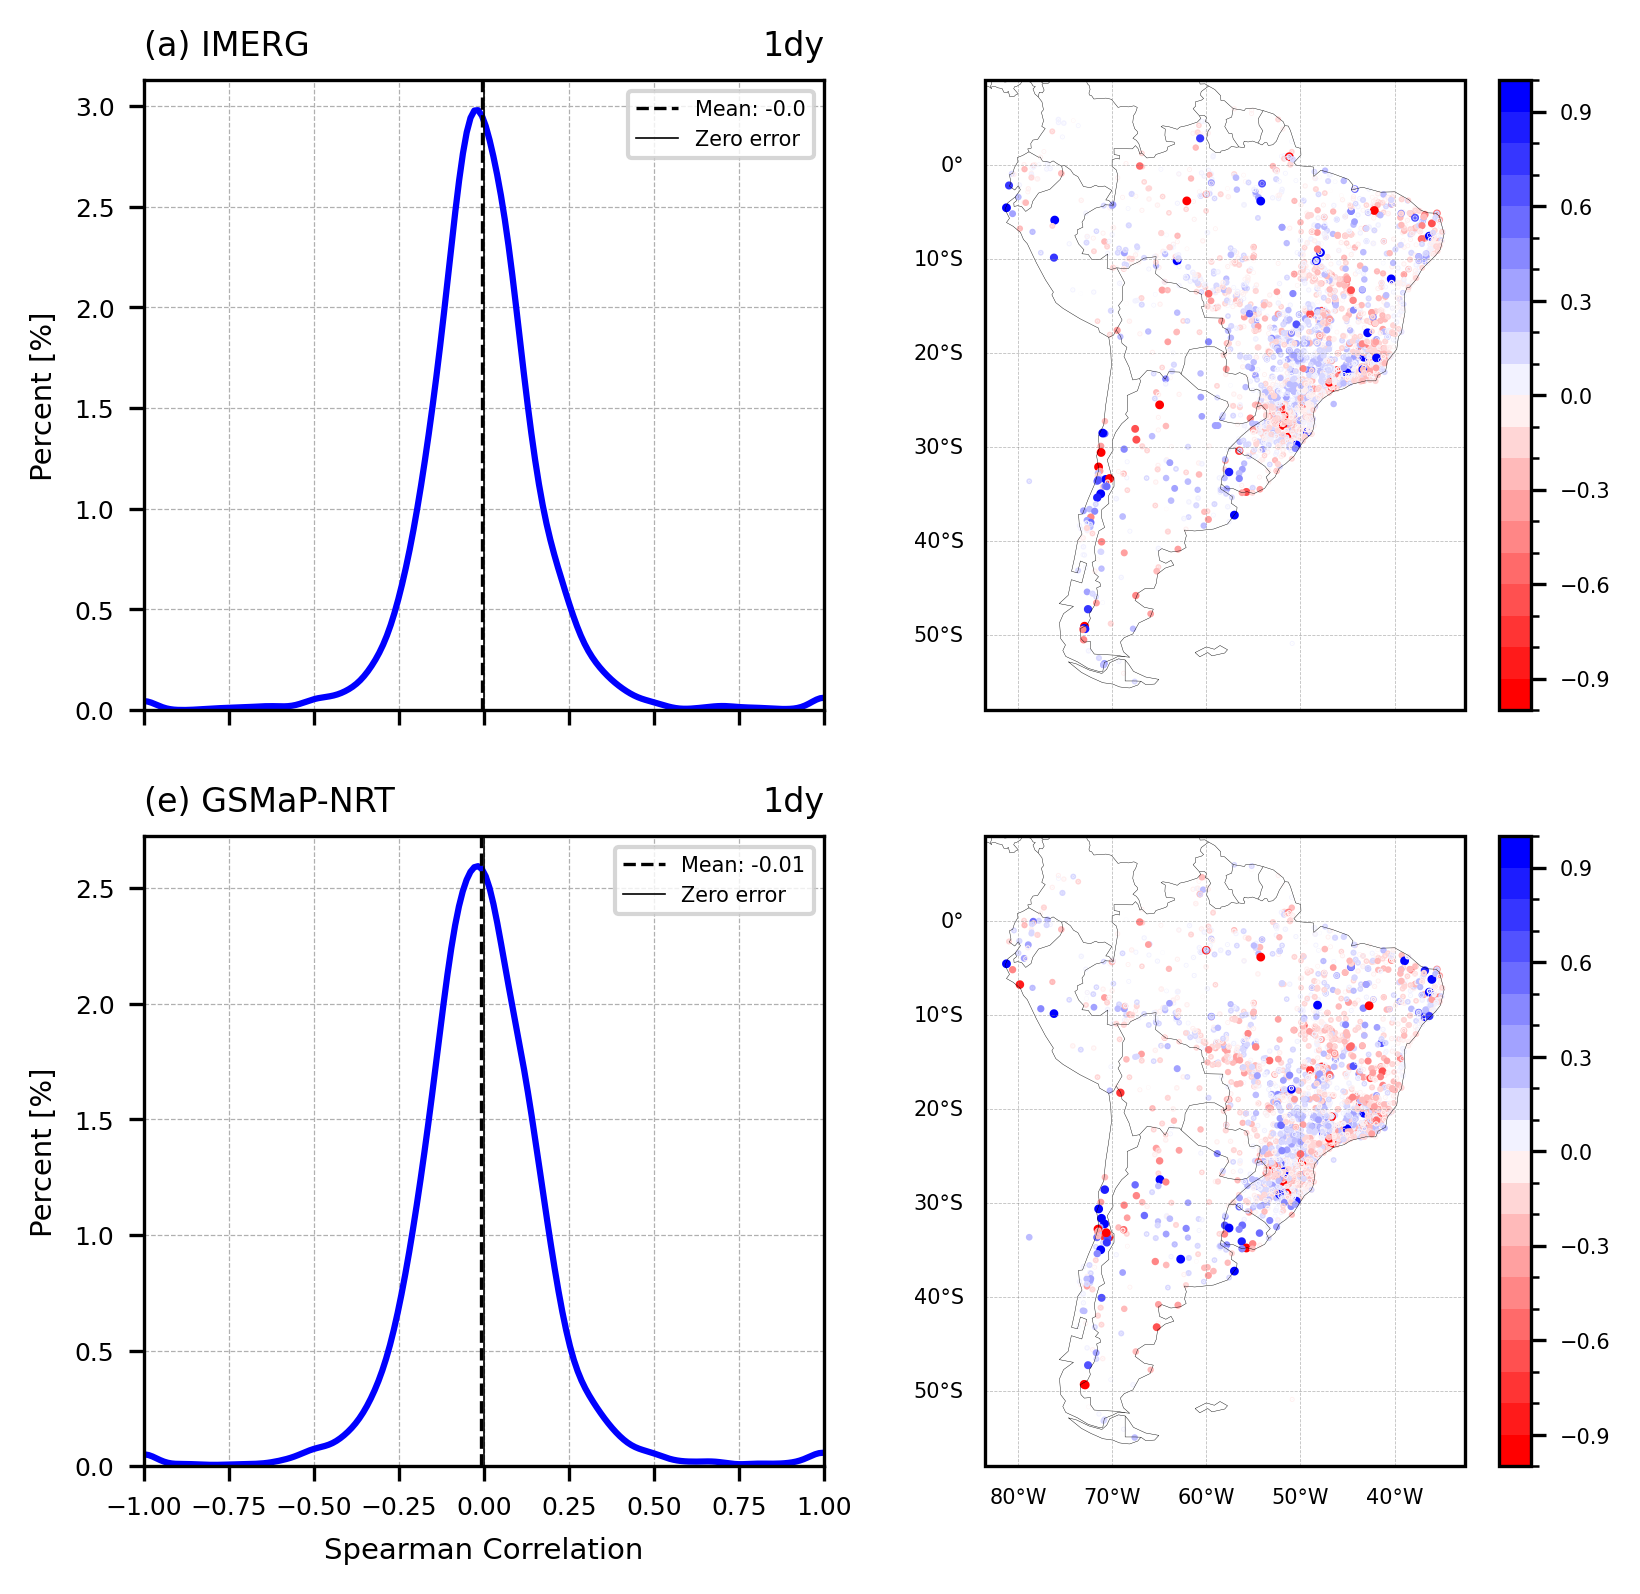

In [15]:
levels = np.arange(-1.0, 1.1, 0.1)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

cmap = plt.cm.bwr_r

fig = plt.figure(figsize=(6,6),dpi=300)
gs = gridspec.GridSpec(2,2)

#==================================================================================================
ax1 = plt.subplot(gs[0, 0])
sns.kdeplot(COR_IMERG,color='blue',cumulative=False,fill=False,multiple="stack",ax=ax1)
ax1.axvline(np.nanmean(COR_IMERG),color='k',linestyle='--',linewidth=0.8, label=f'Mean: {np.round(np.nanmean(COR_IMERG),2)}')
ax1.axvline(0,color='k',linestyle='-',linewidth=0.4, label=f'Zero error')
ax1.set_ylabel('Percent [%]',fontsize=7)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_xlim(-1,1)
ax1.set_xticklabels([])
ax1.set_title('(a) IMERG', loc='left', fontsize=8)
ax1.set_title('1dy', loc='right', fontsize=8)
ax1.legend(fontsize=5,loc=1)

#================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.1, linestyle='-', edgecolor='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

a1 = ax1.scatter(lon_ref,lat_ref,s=5*abs(COR_IMERG/np.nanmax(COR_IMERG)),marker='.',c=COR_IMERG,cmap=cmap,norm=norm)
cbar = plt.colorbar(a1, fraction=0.058)
cbar.ax.tick_params(labelsize=5)

#==================================================================================================
ax1 = plt.subplot(gs[1, 0])
sns.kdeplot(COR_GSMaP_NRT,color='blue',cumulative=False,fill=False,multiple="stack",ax=ax1)
ax1.axvline(np.nanmean(COR_GSMaP_NRT),color='k',linestyle='--',linewidth=0.8, label=f'Mean: {np.round(np.nanmean(COR_GSMaP_NRT),2)}')
ax1.axvline(0,color='k',linestyle='-',linewidth=0.4, label=f'Zero error')
ax1.set_ylabel('Percent [%]',fontsize=7)
ax1.set_xlabel('Spearman Correlation',fontsize=7)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_xlim(-1,1)
ax1.set_title('(e) GSMaP-NRT', loc='left', fontsize=8)
ax1.set_title('1dy', loc='right', fontsize=8)
ax1.legend(fontsize=5,loc=1)

#================================================================================
ax1 = plt.subplot(gs[1, 1], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.1, linestyle='-', edgecolor='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

a1 = ax1.scatter(lon_ref,lat_ref,s=5*abs(COR_GSMaP_NRT/np.nanmax(COR_GSMaP_NRT)),marker='.',c=COR_GSMaP_NRT,cmap=cmap,norm=norm)
cbar = plt.colorbar(a1, fraction=0.058)
cbar.ax.tick_params(labelsize=5)

#==================================================================================================
plt.subplots_adjust(wspace=0.05, hspace=0.2)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

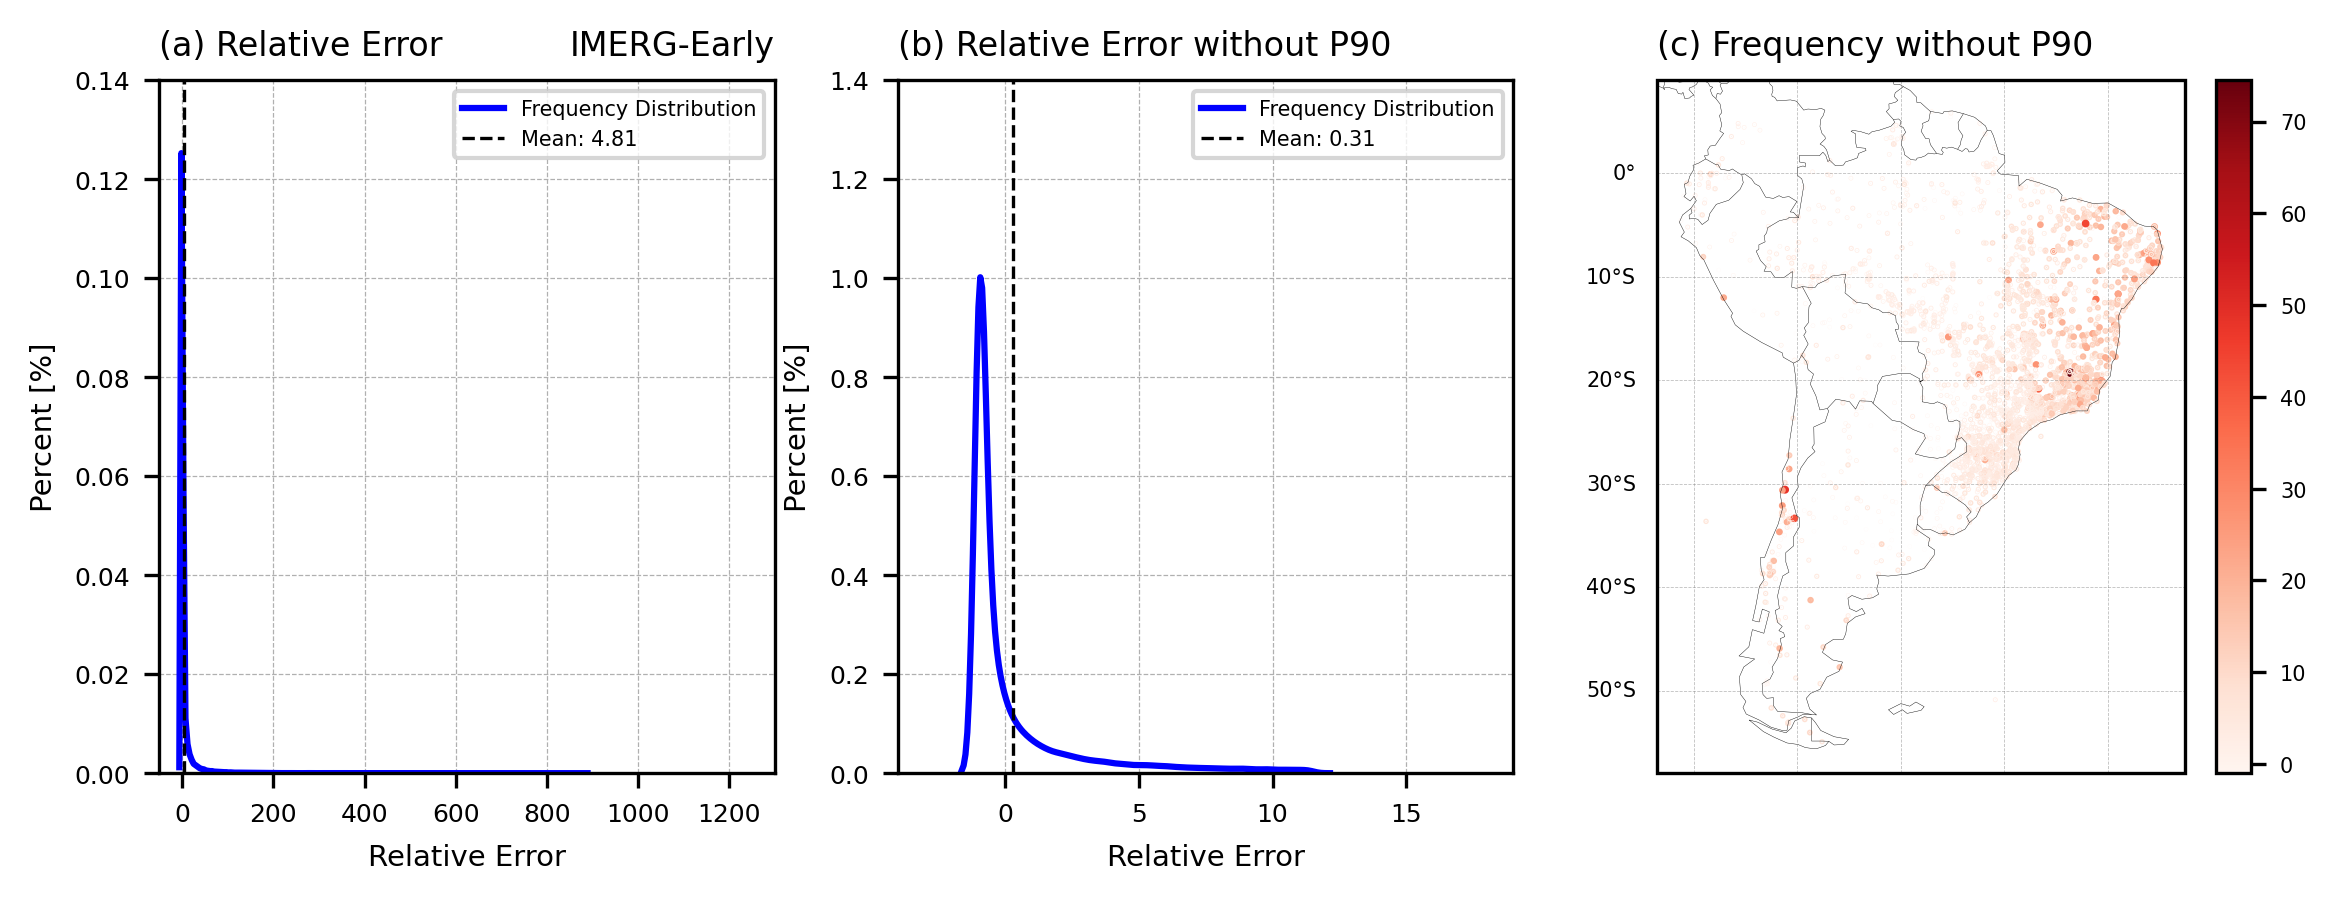

In [91]:
perc = 90

levels = np.arange(-0.6, 0.7, 0.1)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)
norm = None

cmap = plt.cm.Reds

fig = plt.figure(figsize=(9,3),dpi=300)
gs = gridspec.GridSpec(1,3)

#==================================================================================================
ax1 = plt.subplot(gs[0, 0])
sns.kdeplot(RE_IMERG,color='blue',cumulative=False,fill=False,multiple="stack",ax=ax1, label='Frequency Distribution')
ax1.axvline(np.nanmean(RE_IMERG),color='k',linestyle='--',linewidth=0.8, label=f'Mean: {np.round(np.nanmean(RE_IMERG),2)}')
# ax1.axvline(0,color='k',linestyle='-',linewidth=0.4, label=f'Zero error')
ax1.set_ylabel('Percent [%]',fontsize=7)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_xlim(-50,1300)
ax1.set_ylim(0,0.14)
ax1.set_xlabel('Relative Error',fontsize=7)
ax1.set_title('(a) Relative Error', loc='left', fontsize=8)
ax1.set_title('IMERG-Early', loc='right', fontsize=8)
ax1.legend(fontsize=5,loc=1)

#==================================================================================================
ax1 = plt.subplot(gs[0, 1])
RE_IMERG = np.array(RE_IMERG)
sns.kdeplot(RE_IMERG[RE_IMERG<np.percentile(RE_IMERG,perc)],color='blue',cumulative=False,fill=False,multiple="stack",ax=ax1, label='Frequency Distribution')
ax1.axvline(np.nanmean(RE_IMERG[RE_IMERG<np.percentile(RE_IMERG,perc)]),color='k',linestyle='--',linewidth=0.8, label=f'Mean: {np.round(np.nanmean(RE_IMERG[RE_IMERG<np.percentile(RE_IMERG,perc)]),2)}')
# ax1.axvline(0,color='k',linestyle='-',linewidth=0.4, label=f'Zero error')
ax1.set_ylabel('Percent [%]',fontsize=7)
ax1.set_xlabel('Relative Error',fontsize=7)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_xlim(-4,19)
ax1.set_ylim(0,1.4)
ax1.set_title('(b) Relative Error without P90', loc='left', fontsize=8)
ax1.legend(fontsize=5,loc=1)

#==================================================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.1, linestyle='-', edgecolor='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}
ax1.set_title('(c) Frequency without P90', loc='left', fontsize=8)

a1 = ax1.scatter(lon_ref,lat_ref,s=5*abs(MRE_IMERG/np.nanmax(MRE_IMERG)),marker='.',c=MRE_IMERG,cmap=cmap)
cbar = plt.colorbar(a1, fraction=0.058)
cbar.ax.tick_params(labelsize=5)

#==================================================================================================
plt.subplots_adjust(wspace=0.2, hspace=0.2)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)


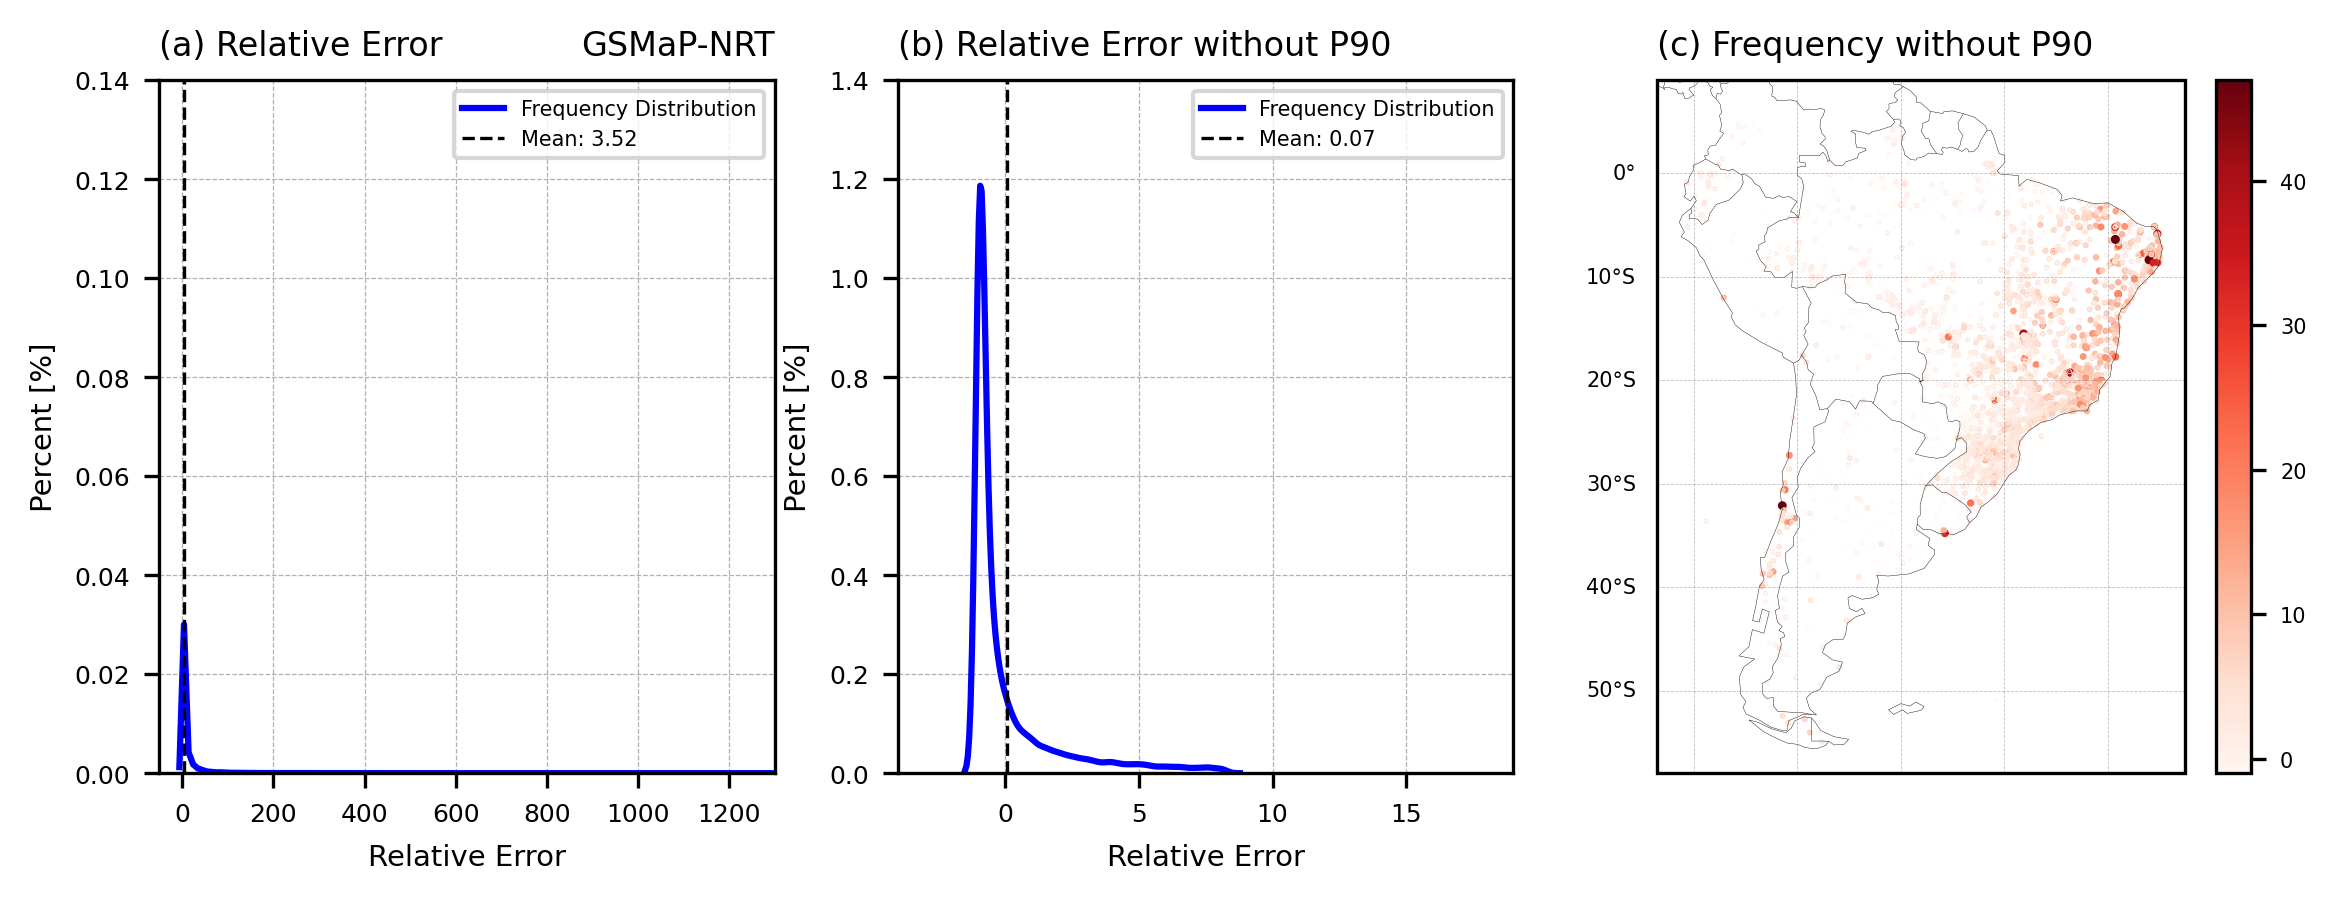

In [92]:
perc = 90

levels = np.arange(-0.6, 0.7, 0.1)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)
norm = None

cmap = plt.cm.Reds

fig = plt.figure(figsize=(9,3),dpi=300)
gs = gridspec.GridSpec(1,3)

#==================================================================================================
ax1 = plt.subplot(gs[0, 0])
sns.kdeplot(RE_GSMaP_NRT,color='blue',cumulative=False,fill=False,multiple="stack",ax=ax1, label='Frequency Distribution')
ax1.axvline(np.nanmean(RE_GSMaP_NRT),color='k',linestyle='--',linewidth=0.8, label=f'Mean: {np.round(np.nanmean(RE_GSMaP_NRT),2)}')
# ax1.axvline(0,color='k',linestyle='-',linewidth=0.4, label=f'Zero error')
ax1.set_ylabel('Percent [%]',fontsize=7)
ax1.set_xlabel('Relative Error',fontsize=7)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_xlim(-50,1300)
ax1.set_ylim(0,0.14)
ax1.set_title('(a) Relative Error', loc='left', fontsize=8)
ax1.set_title('GSMaP-NRT', loc='right', fontsize=8)
ax1.legend(fontsize=5,loc=1)

#==================================================================================================
ax1 = plt.subplot(gs[0, 1])
RE_GSMaP_NRT = np.array(RE_GSMaP_NRT)
sns.kdeplot(RE_GSMaP_NRT[RE_GSMaP_NRT<np.percentile(RE_GSMaP_NRT,perc)],color='blue',cumulative=False,fill=False,multiple="stack",ax=ax1, label='Frequency Distribution')
ax1.axvline(np.nanmean(RE_GSMaP_NRT[RE_GSMaP_NRT<np.percentile(RE_GSMaP_NRT,perc)]),color='k',linestyle='--',linewidth=0.8, label=f'Mean: {np.round(np.nanmean(RE_GSMaP_NRT[RE_GSMaP_NRT<np.percentile(RE_GSMaP_NRT,perc)]),2)}')
# ax1.axvline(0,color='k',linestyle='-',linewidth=0.4, label=f'Zero error')
ax1.set_ylabel('Percent [%]',fontsize=7)
ax1.set_xlabel('Relative Error',fontsize=7)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_xlim(-4,19)
ax1.set_ylim(0,1.4)
ax1.set_title('(b) Relative Error without P90', loc='left', fontsize=8)
ax1.legend(fontsize=5,loc=1)

#==================================================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.1, linestyle='-', edgecolor='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}
ax1.set_title('(c) Frequency without P90', loc='left', fontsize=8)

a1 = ax1.scatter(lon_ref,lat_ref,s=5*abs(MRE_GSMaP_NRT/np.nanmax(MRE_GSMaP_NRT)),marker='.',c=MRE_GSMaP_NRT,cmap=cmap)
cbar = plt.colorbar(a1, fraction=0.058)
cbar.ax.tick_params(labelsize=5)

#==================================================================================================
plt.subplots_adjust(wspace=0.2, hspace=0.2)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)


In [17]:
RAIN_OBS = np.array(RAIN_OBS)

RAIN_IMERG = np.array(RAIN_IMERG)
mask_IMERG = (RAIN_OBS != 0) & (RAIN_IMERG != 0)

RAIN_GSMaP_NRT = np.array(RAIN_GSMaP_NRT)
mask_GSMaP_NRT = (RAIN_OBS != 0) & (RAIN_GSMaP_NRT != 0)

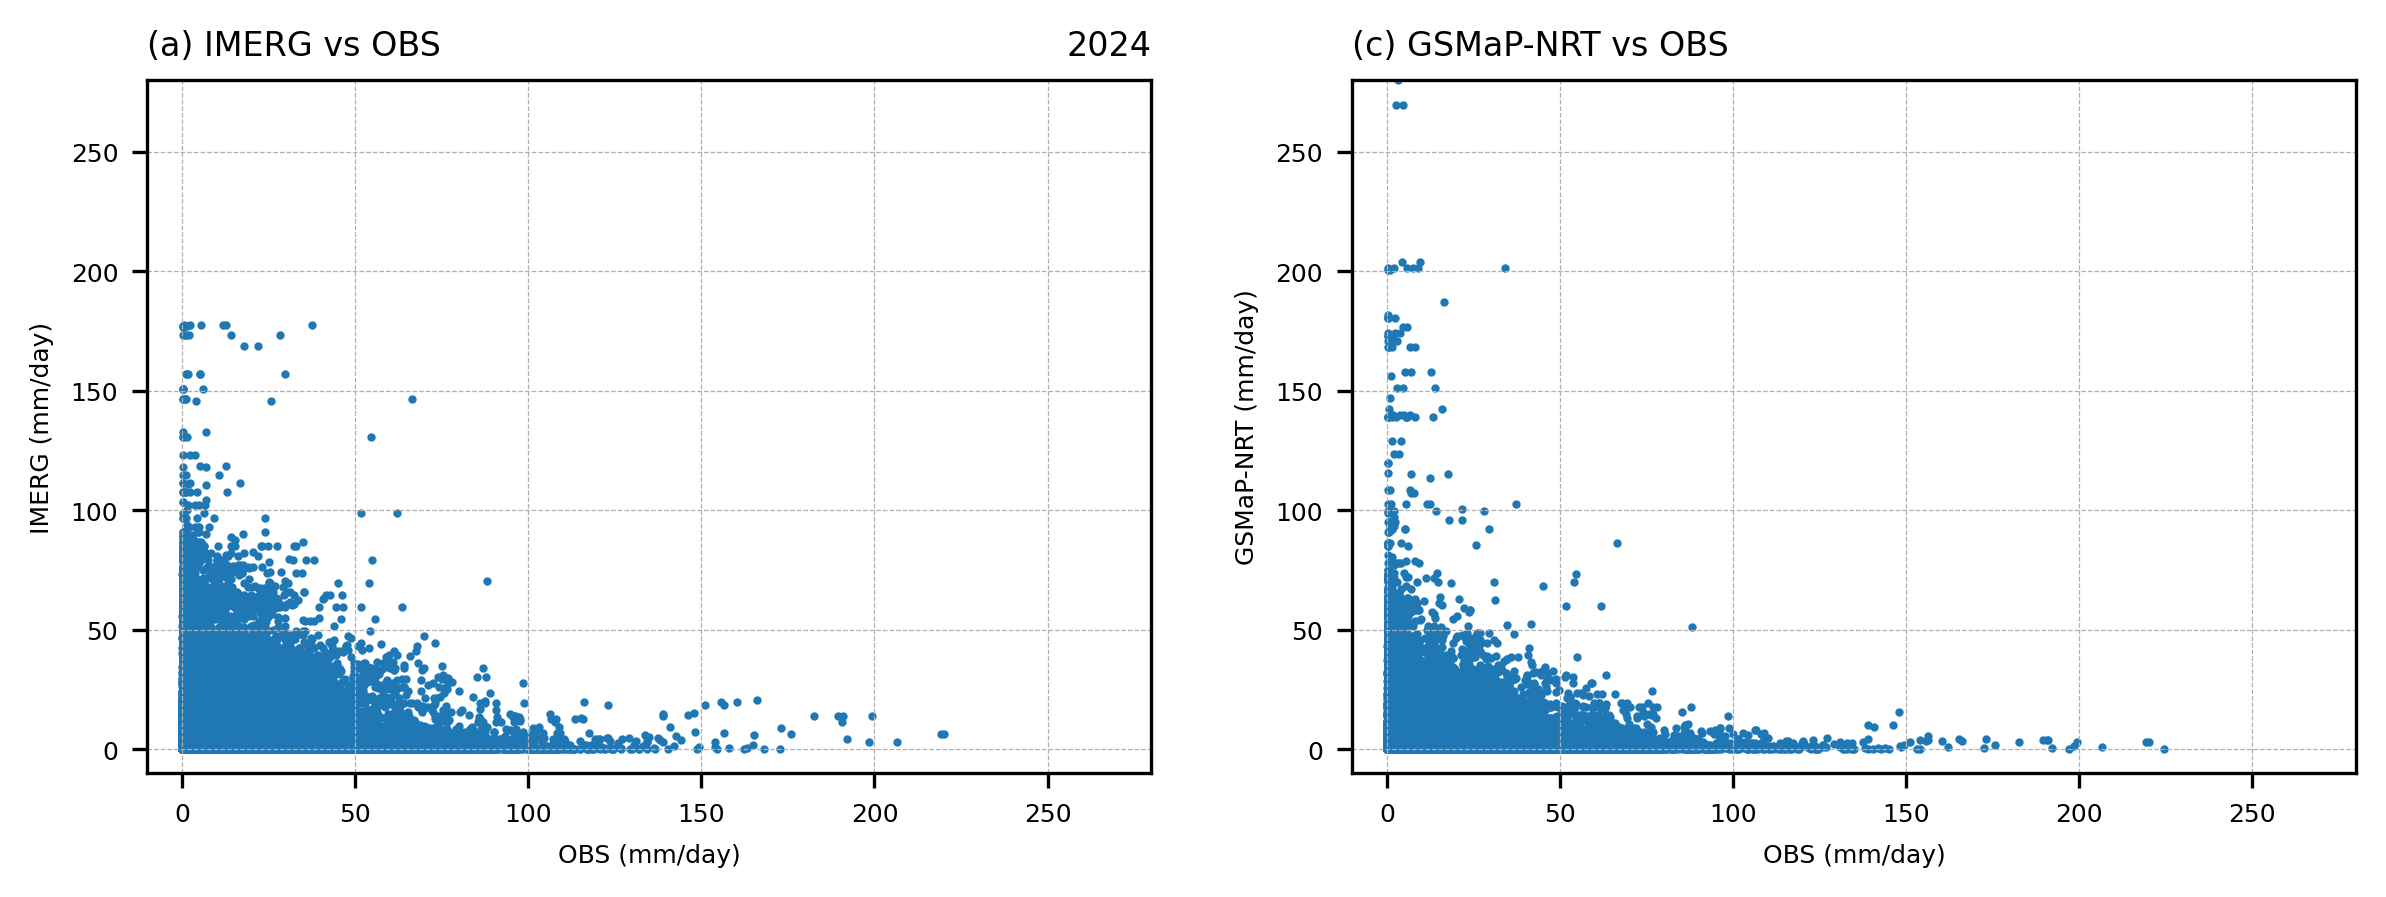

In [18]:
fig = plt.figure(figsize=(9.5,3),dpi=300)
gs = gridspec.GridSpec(1,2)

#==================================================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(RAIN_OBS[mask_IMERG], RAIN_IMERG[mask_IMERG], s=1)
ax1.set_ylim(-10, 280)
ax1.set_xlim(-10, 280)
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.set_xlabel('OBS (mm/day)', fontsize=6)
ax1.set_ylabel('IMERG (mm/day)', fontsize=6)
ax1.set_title('(a) IMERG vs OBS', fontsize=8, loc='left')
ax1.set_title('2024', fontsize=8, loc='right')

#==================================================================================================
ax1 = plt.subplot(gs[0, 1])
ax1.scatter(RAIN_OBS[mask_GSMaP_NRT], RAIN_GSMaP_NRT[mask_GSMaP_NRT], s=1)
ax1.set_ylim(-10, 280)
ax1.set_xlim(-10, 280)
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.set_xlabel('OBS (mm/day)', fontsize=6)
ax1.set_ylabel('GSMaP-NRT (mm/day)', fontsize=6)
ax1.set_title('(c) GSMaP-NRT vs OBS', fontsize=8, loc='left')

#==================================================================================================
ax1.set_facecolor('white')
fig.patch.set_alpha(0)

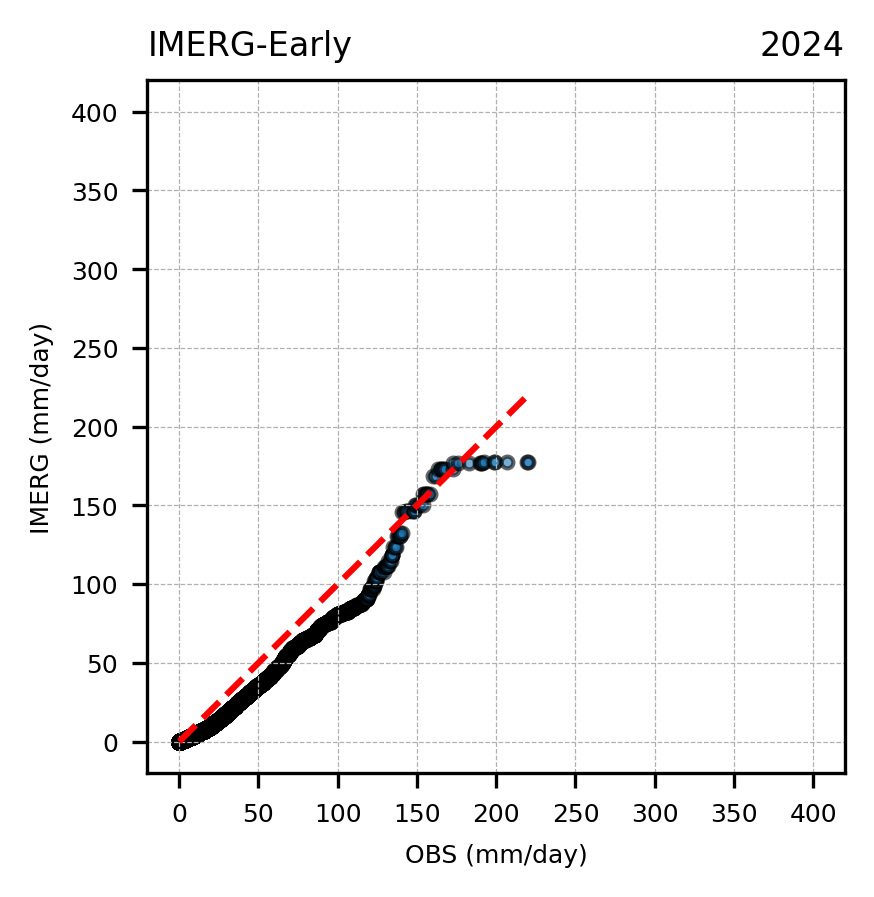

In [54]:
fig = plt.figure(figsize=(3,3),dpi=300)
gs = gridspec.GridSpec(1,1)

#==================================================================================================
ax1 = plt.subplot(gs[0, 0])

OBS_sorted = np.sort(RAIN_OBS[mask_IMERG])
IMERG_sorted = np.sort(RAIN_IMERG[mask_IMERG])

ax1.scatter(OBS_sorted, IMERG_sorted, alpha=0.6, edgecolor='k',s=8)
ax1.plot([OBS_sorted.min(), OBS_sorted.max()],
        [OBS_sorted.min(), OBS_sorted.max()],
        'r--', label='1:1 line')
ax1.set_xlim(-20,420)
ax1.set_ylim(-20,420)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_title('IMERG-Early', fontsize=8, loc='left')
ax1.set_title('2024', fontsize=8, loc='right')
ax1.set_xlabel('OBS (mm/day)', fontsize=6)
ax1.set_ylabel('IMERG (mm/day)', fontsize=6)

#==================================================================================================
ax1.set_facecolor('white')
fig.patch.set_alpha(0)

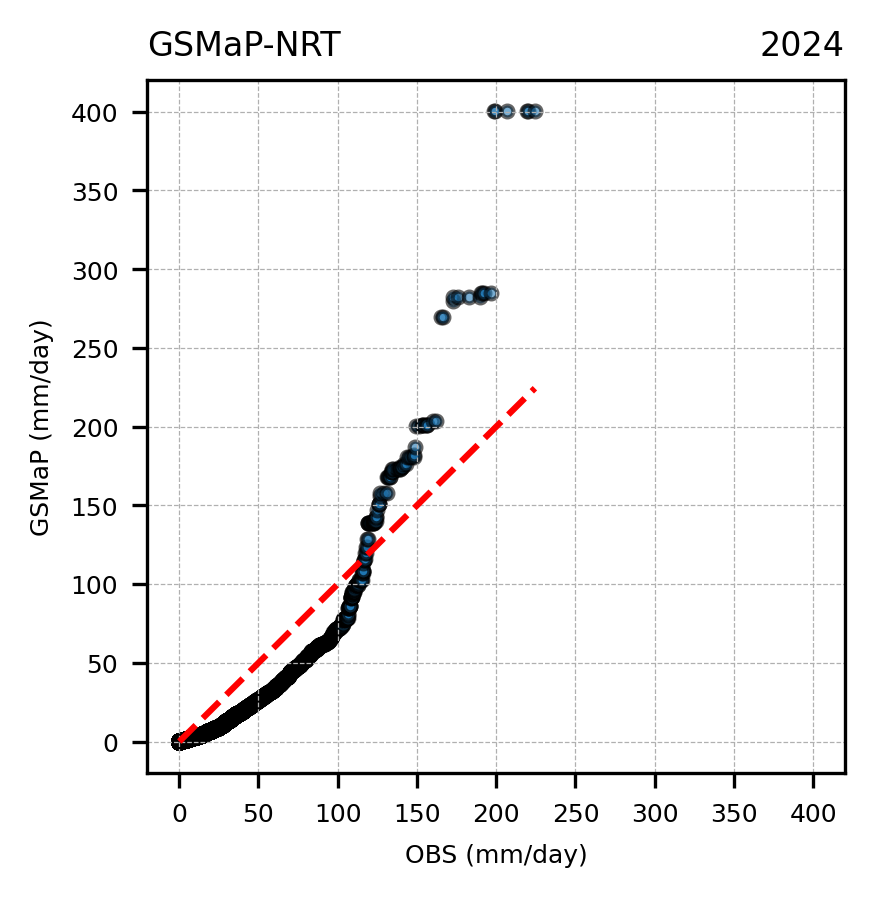

In [53]:
fig = plt.figure(figsize=(3,3),dpi=300)
gs = gridspec.GridSpec(1,1)

#==================================================================================================
ax1 = plt.subplot(gs[0, 0])

OBS_sorted = np.sort(RAIN_OBS[mask_GSMaP_NRT])
GSMaP_NRT_sorted = np.sort(RAIN_GSMaP_NRT[mask_GSMaP_NRT])

ax1.scatter(OBS_sorted, GSMaP_NRT_sorted, alpha=0.6, edgecolor='k',s=8)
ax1.plot([OBS_sorted.min(), OBS_sorted.max()],
        [OBS_sorted.min(), OBS_sorted.max()],
        'r--', label='1:1 line')
ax1.set_xlim(-20,420)
ax1.set_ylim(-20,420)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_title('GSMaP-NRT', fontsize=8, loc='left')
ax1.set_title('2024', fontsize=8, loc='right')
ax1.set_xlabel('OBS (mm/day)', fontsize=6)
ax1.set_ylabel('GSMaP (mm/day)', fontsize=6)

#==================================================================================================
ax1.set_facecolor('white')
fig.patch.set_alpha(0)